In [1]:
#import all necessary libs
import warnings
warnings.filterwarnings('ignore')
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from collections import Counter
import string
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
import tensorflow as tf

In [2]:
# read the data file
data = pd.read_json("Sarcasm_Headlines_Dataset.json",lines=True)
df=data.copy()

In [3]:
# CHeck the top 5 rows of the data set
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [4]:
# describtion of data
df.describe()

,is_sarcastic
count,28619.000000
mean,0.476397
std,0.499451
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [5]:
# check the information of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


In [6]:
df.describe

<bound method NDFrame.describe of        is_sarcastic                                           headline  \
0                 1  thirtysomething scientists unveil doomsday clo...   
1                 0  dem rep. totally nails why congress is falling...   
2                 0  eat your veggies: 9 deliciously different recipes   
3                 1  inclement weather prevents liar from getting t...   
4                 1  mother comes pretty close to using word 'strea...   
...             ...                                                ...   
28614             1       jews to celebrate rosh hashasha or something   
28615             1  internal affairs investigator disappointed con...   
28616             0  the most beautiful acceptance speech this week...   
28617             1  mars probe destroyed by orbiting spielberg-gat...   
28618             1                 dad clarifies this not a food stop   

                                            article_link  
0      https://www

### Dataset Exploratory Data Analysis

In the dataset, if headline is sarcastic, "is_sarcastic" column value 1. If not sarcastic, value=0. Also article value is provided. But our main focus is to build a model that can detect sarcastic news based on "headline" and "is_sarcastic" column.

In [7]:
#lets find if there is any NaN valus, because NaN values give wrong visualization
df.isna().sum()

is_sarcastic    0
headline        0
article_link    0
dtype: int64

In [8]:
#Lets drop the "article link" column from dataframe as it is not needed
#del df['article_link']

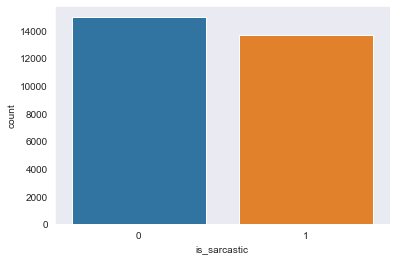

In [9]:
#Lets create a barplot/countplot to compare between sarcastic or non-sarcastic news
sns. set_style("dark")
sns.countplot(df.is_sarcastic);

so there are almost same number of sarcastic and non-sarcastic news.

In [10]:
#  Check the different sourse of news
df.article_link.apply(lambda x: x.split('.')[1]).value_counts()

huffingtonpost    14985
theonion          13634
Name: article_link, dtype: int64

In [11]:
# create website column for sourse link of the news
df['website'] = df.article_link.apply(lambda x: x.split('.')[1])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
 3   website       28619 non-null  object
dtypes: int64(1), object(3)
memory usage: 894.5+ KB


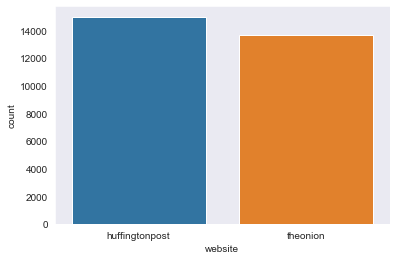

In [12]:
#view different news sourses
sns.countplot(x= df.website ,data=df, order = df['website'].value_counts().index);


In [13]:
sar_acc_tar = df['is_sarcastic'].value_counts()
labels = ['non-sarcastic', 'Sarcastic']
sizes = (np.array((sar_acc_tar / sar_acc_tar.sum())*100))
colors = ['#58D68D', '#9B59B6']

trace = go.Pie(labels=labels, values=sizes, opacity = 0.9, hoverinfo='label+percent',
               marker=dict(colors=colors, line=dict(color='#FFFFFF', width=2)))
layout = go.Layout(
    title='Sarcastic Vs non-sarcastic'
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename="Sa_Ac")

#### Frequent Occuring word (unclean) in Headlines

In [14]:
all_words = df['headline'].str.split(expand=True).unstack().value_counts()
data = [go.Bar(
            x = all_words.index.values[2:50],
            y = all_words.values[2:50],
            marker= dict(colorscale='Viridis',
                         color = all_words.values[2:100]
                        ),
            text = 'Word counts'
    )]

layout = go.Layout(
    title='Frequent Occuring word (unclean) in Headlines'
)

fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='basic-bar')


From the above plot its clearly evident that the headlines need to be cleaned as the top 50 most occuring words are joing words and indirect words which does not provide any meaning.

## Tokenization
Tokenization is the process of breaking up the given text into units called tokens. The tokens may be words or number or punctuation mark. Tokenization does this task by locating word boundaries. Ending point of a word and beginning of the next word is called word boundaries. Tokenization is also known as word segmentation.

Before tokenization we will remove the unnecessary characters from data

In [15]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;:]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    return text
    
df['headline'] = df['headline'].apply(clean_text)


In [16]:
#non-sarcatic headlines tokenization
n_sar_list=[]
for i in df[df['is_sarcastic']==0]['headline'].values:
    n_sar_list.append(i.split())

In [17]:
n_sar=[]
for i in range(len(n_sar_list)):
    for j in n_sar_list[i]:
        n_sar.append(j)

In [18]:
#sarcatic headlines tokenization
sar_list=[]
for i in df[df['is_sarcastic']==1]['headline'].values:
    l=i.split()
    sar_list.append(l)
    

In [19]:
sar = []
for i in range(len(sar_list)):
    for j in n_sar_list[i]:
        sar.append(j)      

## Removing Stopwords

A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that a search engine has been programmed to ignore, both when indexing entries for searching and when retrieving them as the result of a search query.

We would not want these words taking up space in our database, or taking up valuable processing time. For this, we can remove them easily, by storing a list of words that you consider to be stop words.

We will remove the stopwords provided by NLTK package from our headlines.

Lets find some somewords and clean them because stopwords have no meaning for a sentence. we will use python library(nltk) to detect them.

In [20]:
#set and define stop word
#nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))
punctuation = list(string.punctuation)
stopwords.update(punctuation)

In [21]:
sar_list_restp = [word for word in sar if word.lower() not in stopwords]
n_sar_list_restp = [word for word in n_sar if word.lower() not in stopwords]

print("Length of original Sarcasm list: {0} words\n"
      "Length of Sarcasm list after stopwords removal: {1} words"
      .format(len(sar), len(sar_list_restp)))

print("=="*46)

print("Length of original non_sarcastic list: {0} words\n"
      "Length of non_sarcastic list after stopwords removal: {1} words"
      .format(len(n_sar), len(n_sar_list_restp)))

Length of original Sarcasm list: 133668 words
Length of Sarcasm list after stopwords removal: 93676 words
Length of original non_sarcastic list: 146872 words
Length of non_sarcastic list after stopwords removal: 102913 words


In [22]:
def remove_stopwd(text):    
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

df['headline']=df['headline'].apply(remove_stopwd)

In [23]:
df.head()

,is_sarcastic,headline,article_link,website
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...,theonion
1,0,dem rep totally nails congress falling short g...,https://www.huffingtonpost.com/entry/donna-edw...,huffingtonpost
2,0,eat veggies 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...,huffingtonpost
3,1,inclement weather prevents liar getting work,https://local.theonion.com/inclement-weather-p...,theonion
4,1,mother comes pretty close using word streaming...,https://www.theonion.com/mother-comes-pretty-c...,theonion


#### Top 30 Occuring words after removing Stopwords from Headlines - Sarcasm Vs Non-sarcasm

In [24]:
#Data cleaning for getting top 30
sar_cnt = Counter(sar_list_restp)
acc_cnt = Counter(n_sar_list_restp)

#Dictonary to Dataframe
sar_cnt_df = pd.DataFrame(list(sar_cnt.items()), columns = ['Words', 'Freq'])
sar_cnt_df = sar_cnt_df.sort_values(by=['Freq'], ascending=False)
acc_cnt_df = pd.DataFrame(list(acc_cnt.items()), columns = ['Words', 'Freq'])
acc_cnt_df = acc_cnt_df.sort_values(by=['Freq'], ascending=False)

#Top 30
sar_cnt_df_30 = sar_cnt_df.head(30)
acc_cnt_df_30 = acc_cnt_df.head(30)

In [25]:
#Plotting the top 30 Sarcasm Vs Acclaim
from plotly import tools
sar_tr  = go.Bar(
    x=sar_cnt_df_30['Freq'],
    y=sar_cnt_df_30['Words'],
    name='Sarcasm',
    marker=dict(
        color='rgba(155, 89, 182, 0.6)',
        line=dict(
            color='rgba(155, 89, 182, 1.0)',
            width=.3,
        )
    ),
    orientation='h',
    opacity=0.6
)

acc_tr  = go.Bar(
    x=acc_cnt_df_30['Freq'],
    y=acc_cnt_df_30['Words'],
    name='non-sarcasm',
    marker=dict(
        color='rgba(88, 214, 141, 0.6)',
        line=dict(
            color='rgba(88, 214, 141, 1.0)',
            width=.5,
        )
    ),
    orientation='h',
    opacity=0.6
)

fig = tools.make_subplots(rows=2, cols=1, subplot_titles=('Top 30 Most occuring words in Sarcasm Headlines',
                                                          'Top 30 Most occuring words in non-sarcastic Headlines'))

fig.append_trace(sar_tr, 1, 1)
fig.append_trace(acc_tr, 2, 1)


fig['layout'].update(height=1600, width=800)

iplot(fig, filename='sar_vs_n_sar')

C:\Users\Arun Kumar\AppData\Roaming\Python\Python37\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



### Stemming
In linguistic morphology and information retrieval, stemming is the process of reducing inflected (or sometimes derived) words to their word stem, base or root form - generally a written word form. The stem need not be identical to the morphological root of the word; it is usually sufficient that related words map to the same stem, even if this stem is not in itself a valid root.

Source:
https://en.wikipedia.org/wiki/Stemming

NLTK provides three different forms of steamming namely Porter stemming algorithm, the lancaster stemmer and the Snowball stemmer. Here, for our analysis we will be using Snowball stemmer.

In [26]:
# Example of snowballstemmer algorithm
stemmer = nltk.stem.SnowballStemmer("english", ignore_stopwords=True)
print("The stemmed form of learning is: {}".format(stemmer.stem("learning")))
print("The stemmed form of learns is: {}".format(stemmer.stem("learns")))
print("The stemmed form of learn is: {}".format(stemmer.stem("learn")))
print("=="*46)
print("The stemmed form of leaves is: {}".format(stemmer.stem("leaves")))
print("=="*46)

The stemmed form of learning is: learn
The stemmed form of learns is: learn
The stemmed form of learn is: learn
The stemmed form of leaves is: leav


Here is the caveat in using stemming. In the above example for the word 'leaves', it just stemms the word. As the name 'stemming' suggest, it at times simply stems the word which will become meaningless. So, to overcome this issue we have lemmatization.

### Lemmatisation


Lemmatisation (or lemmatization) in linguistics is the process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word's lemma, or dictionary form. Unlike a stemmer, lemmatizing the dataset aims to reduce words based on an actual dictionary or vocabulary (the Lemma) and therefore will not chop off words into stemmed forms that do not carry any lexical meaning.

Source:
https://en.wikipedia.org/wiki/Lemmatisation

In [27]:
#download wordnet 
# nltk.download('wordnet')

In [28]:
lemm = WordNetLemmatizer()
print("The lemmatized form of leaves is: {}".format(lemm.lemmatize("leaves")))

The lemmatized form of leaves is: leaf


In [29]:
sar_wost_lem=[]
sar_list_lemm = [lemm.lemmatize(word) for word in sar_list_restp]
sar_wost_lem.append(sar_list_lemm)


In [30]:
n_sar_wost_lem = []
n_sar_list_lemm = [lemm.lemmatize(word) for word in n_sar_list_restp]
n_sar_wost_lem.append(n_sar_list_lemm)


In [31]:
# top 50 frequant sarcastic word
sar_cnt_df.head(50).reset_index(drop=True)

,Words,Freq
0,trump,923
1,new,617
2,donald,403
3,us,329
4,trumps,325
5,says,320
6,one,239
7,women,231
8,first,212
9,man,207


### Bi-grams

A bigram or digram is a sequence of two adjacent elements from a string of tokens, which are typically letters, syllables, or words. A bigram is an n-gram for n=2. The frequency distribution of every bigram in a string is commonly used for simple statistical analysis of text in many applications, including in computational linguistics, cryptography, speech recognition, and so on.

Source:
https://en.wikipedia.org/wiki/Bigram

In [32]:
sar_wost_lem_df = pd.DataFrame({'sarcasm':sar_wost_lem})
n_sar_wost_lem_df = pd.DataFrame({'Non-sarcasm':n_sar_wost_lem})

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    ngrams = zip(*[text[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

#Plotting the Bigram plot
from collections import defaultdict
freq_dict = defaultdict(int)
for sent in sar_wost_lem_df["sarcasm"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
sar_2 = horizontal_bar_chart(fd_sorted.head(50), '#9B59B6')


freq_dict = defaultdict(int)
for sent in n_sar_wost_lem_df["Non-sarcasm"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
acc_2 = horizontal_bar_chart(fd_sorted.head(50), '#58D68D')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent bigrams of Sarcasm Headlines", 
                                          "Frequent bigrams of Non-sarcasm Headlines"])
fig.append_trace(sar_2, 1, 1)
fig.append_trace(acc_2, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Bigram Plots Sarcasm Vs Non-sarcasm after removing Stopwords")
iplot(fig, filename='word-plots')

C:\Users\Arun Kumar\AppData\Roaming\Python\Python37\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



### Trigram

In [33]:
#Plotting the Trigram plot
from collections import defaultdict
freq_dict = defaultdict(int)
for sent in sar_wost_lem_df["sarcasm"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
sar_2 = horizontal_bar_chart(fd_sorted.head(50), '#9B59B6')


freq_dict = defaultdict(int)
for sent in n_sar_wost_lem_df["Non-sarcasm"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
acc_2 = horizontal_bar_chart(fd_sorted.head(50), '#58D68D')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent Trigrams of Sarcasm Headlines", 
                                          "Frequent Trigrams of Non-sarcasm Headlines"])
fig.append_trace(sar_2, 1, 1)
fig.append_trace(acc_2, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Trigram Plots Sarcasm Vs Non-sarcasm after removing Stopwords")
iplot(fig, filename='word-plots')

### Wordcloud

Create wordcloud for top 200 frequant word in all headlines

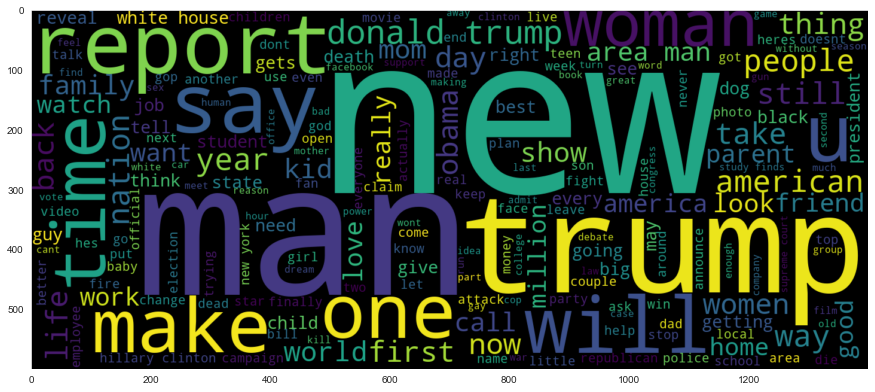

In [34]:
plt.figure(figsize = (15,15)) # non-sarcastic words wordcloud
wordcld = WordCloud(max_words = 200 , width = 1400 , height = 600).generate(" ".join(df.headline))
plt.imshow(wordcld , interpolation = 'bilinear');

Lets create a wordcloud from non-sarcastic news which will give us a view of sights which words are used here most

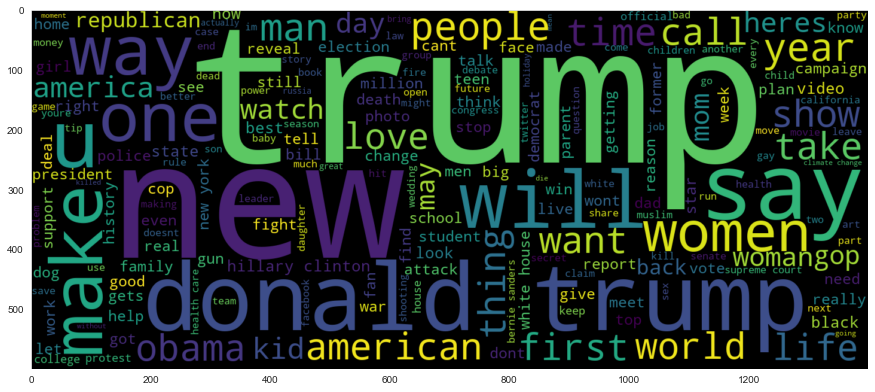

In [35]:
plt.figure(figsize = (15,15)) # non-sarcastic words wordcloud
wordcld = WordCloud(max_words = 200 , width = 1400 , height = 600).generate(" ".join(df[df.is_sarcastic == 0].headline))
plt.imshow(wordcld , interpolation = 'bilinear');

Lets create a wordcloud from sarcastic news which will give us a view of sights which words are used here most

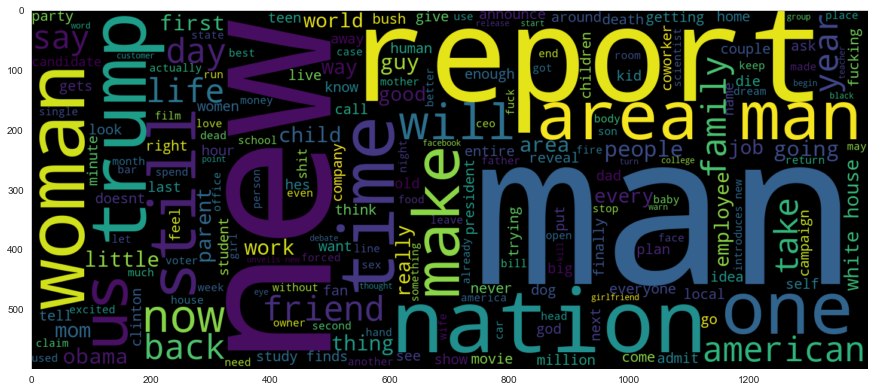

In [36]:
plt.figure(figsize = (15,15)) # non-sarcastic words wordcloud
wordcld = WordCloud(max_words = 200 , width = 1400 , height = 600).generate(" ".join(df[df.is_sarcastic == 1].headline))
plt.imshow(wordcld , interpolation = 'bilinear');

#### Distribution of Sarcasm Vs Non-sarcasm Headlines

In [37]:
## Number of words in the text ##
df["num_words"] = df["headline"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
df["num_unique_words"] = df["headline"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text ##
df["num_chars"] = df["headline"].apply(lambda x: len(str(x)))

## Number of stopwords in the text ##
df["num_stopwords"] = df["headline"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

## Number of punctuations in the text ##
df["num_punctuations"] =df['headline'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of title case words in the text ##
df["num_words_upper"] = df["headline"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the text ##
df["num_words_title"] = df["headline"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the text ##
df["mean_word_len"] = df["headline"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [38]:
df.head()

,is_sarcastic,headline,article_link,website,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...,theonion,7,7,58,0,0,0,0,7.428571
1,0,dem rep totally nails congress falling short g...,https://www.huffingtonpost.com/entry/donna-edw...,huffingtonpost,10,10,67,0,0,0,0,5.800000
2,0,eat veggies 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...,huffingtonpost,6,6,43,0,0,0,0,6.333333
3,1,inclement weather prevents liar getting work,https://local.theonion.com/inclement-weather-p...,theonion,6,6,44,0,0,0,0,6.500000
4,1,mother comes pretty close using word streaming...,https://www.theonion.com/mother-comes-pretty-c...,theonion,8,8,56,0,0,0,0,6.125000


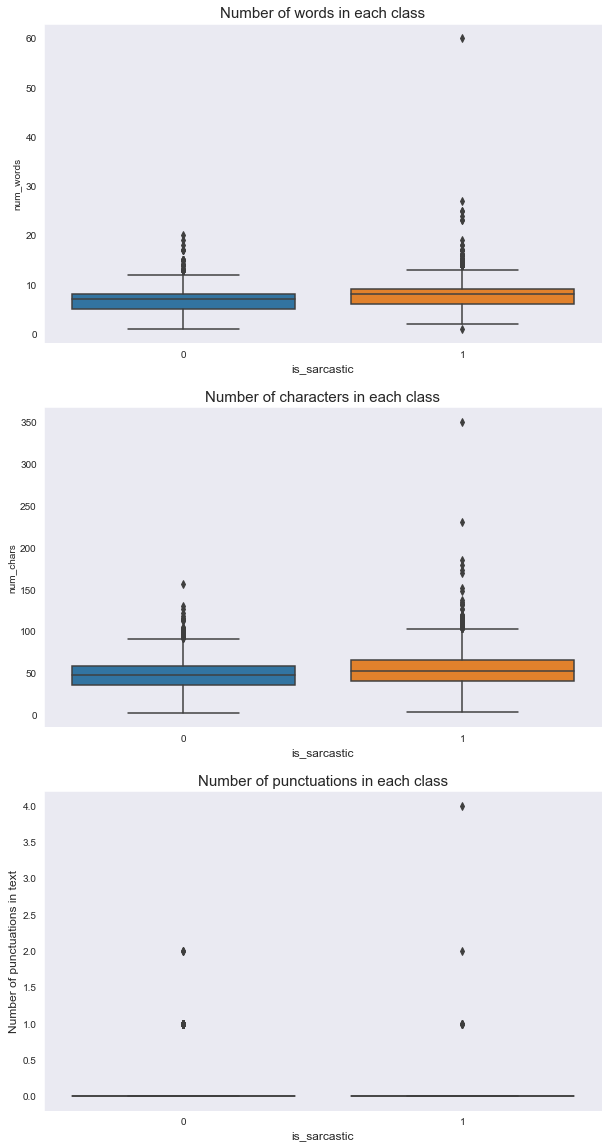

In [39]:
## Truncate some extreme values for better visuals ##
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

df['num_words'].loc[df['num_words']>60] = 60 #truncation for better visuals
df['num_punctuations'].loc[df['num_punctuations']>10] = 10 #truncation for better visuals
df['num_chars'].loc[df['num_chars']>350] = 350 #truncation for better visuals

df['num_words'].loc[df['num_words']>60] = 60 #truncation for better visuals
df['num_punctuations'].loc[df['num_punctuations']>10] = 10 #truncation for better visuals
df['num_chars'].loc[df['num_chars']>350] = 350 #truncation for better visuals

f, axes = plt.subplots(3, 1, figsize=(10,20))
sns.boxplot(x='is_sarcastic', y='num_words', data=df, ax=axes[0])
axes[0].set_xlabel('is_sarcastic', fontsize=12)
axes[0].set_title("Number of words in each class", fontsize=15)

sns.boxplot(x='is_sarcastic', y='num_chars', data=df, ax=axes[1])
axes[1].set_xlabel('is_sarcastic', fontsize=12)
axes[1].set_title("Number of characters in each class", fontsize=15)

sns.boxplot(x='is_sarcastic', y='num_punctuations', data=df, ax=axes[2])
axes[2].set_xlabel('is_sarcastic', fontsize=12)
plt.ylabel('Number of punctuations in text', fontsize=12)
axes[2].set_title("Number of punctuations in each class", fontsize=15)
plt.show()

Lets visualize number of words and each word length in dataset

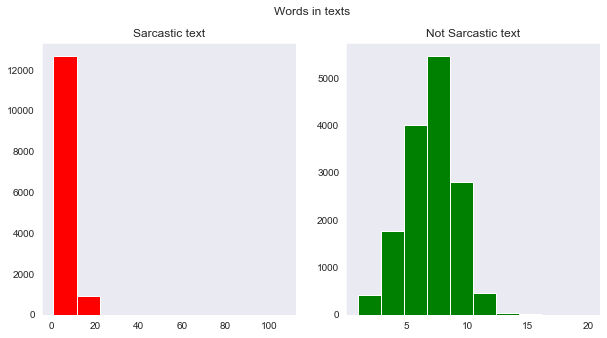

Text(0.5, 0.98, 'Average word length in each text')

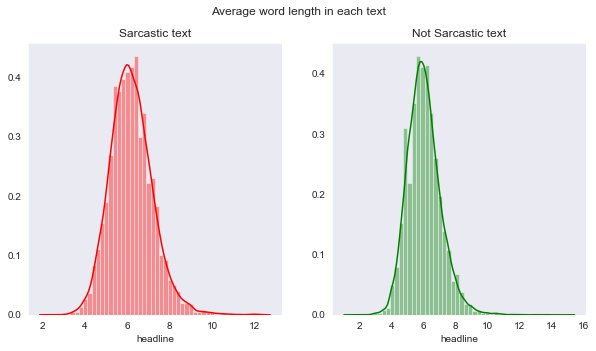

In [40]:
#number of words
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['is_sarcastic']==1]['headline'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic text')
text_len=df[df['is_sarcastic']==0]['headline'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Words in texts')
plt.show()

#average word length
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=df[df['is_sarcastic']==1]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Sarcastic text')
word=df[df['is_sarcastic']==0]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Average word length in each text')

#### Lets split dataset into train and test

In [41]:
X = df.headline
Y = df.is_sarcastic
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state = 0)

# Model Building

### Logistic Regression

In [42]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, Y_train)


logreg_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(logreg_pred, Y_test))
print(classification_report(Y_test, logreg_pred,target_names=['sarcasm','non-sarcasm']))

accuracy 0.7802236198462613
              precision    recall  f1-score   support

     sarcasm       0.79      0.80      0.79      3030
 non-sarcasm       0.77      0.76      0.77      2694

    accuracy                           0.78      5724
   macro avg       0.78      0.78      0.78      5724
weighted avg       0.78      0.78      0.78      5724



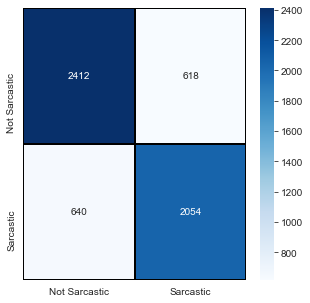

In [43]:
conmat=confusion_matrix(Y_test,logreg_pred)
conmat = pd.DataFrame(conmat , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (5,5))
sns.heatmap(conmat,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic']);

## SVM

In [44]:
svm = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SVC()),
               ])
svm.fit(X_train, Y_train)


svm_pred = svm.predict(X_test)

print('accuracy %s' % accuracy_score(svm_pred, Y_test))
print(classification_report(Y_test, svm_pred,target_names=['sarcasm','non-sarcasm']))

accuracy 0.8139412997903563
              precision    recall  f1-score   support

     sarcasm       0.81      0.85      0.83      3030
 non-sarcasm       0.82      0.78      0.80      2694

    accuracy                           0.81      5724
   macro avg       0.81      0.81      0.81      5724
weighted avg       0.81      0.81      0.81      5724



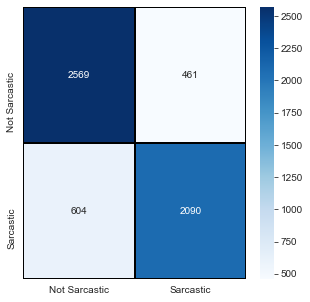

In [45]:
conmat=confusion_matrix(Y_test,svm_pred)
conmat = pd.DataFrame(conmat , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (5,5))
sns.heatmap(conmat,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic']);

### MultinomialNB

In [46]:
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, Y_train)

nb_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(nb_pred, Y_test))
print(classification_report(Y_test, nb_pred,target_names=['sarcasm','non-sarcasm']))

accuracy 0.8085255066387141
              precision    recall  f1-score   support

     sarcasm       0.79      0.86      0.83      3030
 non-sarcasm       0.83      0.75      0.79      2694

    accuracy                           0.81      5724
   macro avg       0.81      0.81      0.81      5724
weighted avg       0.81      0.81      0.81      5724



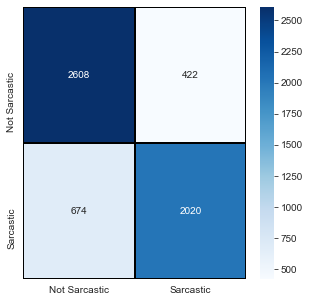

In [47]:
conmat=confusion_matrix(Y_test,nb_pred)
conmat = pd.DataFrame(conmat , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (5,5))
sns.heatmap(conmat,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic']);

### LETS BUILD DEEP LEARNING MODEL AND TRAIN

### Prepare training and testing data for deeplearning model

Now we will use word2vec, tokenization, padding using keras text and word preprocessing libraries.

In [48]:
#lets convert our text data into more acceptable format
#split words from a sentence and keep is sentence in the list which will help us for tokenization
words = []
for i in df.headline.values:
    words.append(i.split())
print("splitted words:",words[:5])

# use genism lib for word2vec wordembedding
import gensim
#Dim for max embedding
EMBEDDING_DIM = 200
#lets create word2vec model
w2v_model = gensim.models.Word2Vec(sentences = words , size=EMBEDDING_DIM , window = 5 , min_count = 1)

splitted words: [['thirtysomething', 'scientists', 'unveil', 'doomsday', 'clock', 'hair', 'loss'], ['dem', 'rep', 'totally', 'nails', 'congress', 'falling', 'short', 'gender', 'racial', 'equality'], ['eat', 'veggies', '9', 'deliciously', 'different', 'recipes'], ['inclement', 'weather', 'prevents', 'liar', 'getting', 'work'], ['mother', 'comes', 'pretty', 'close', 'using', 'word', 'streaming', 'correctly']]


now we will use tokenizer which keep tracks of every word in dataset by assigning an unique token for each word. Also to match length of each sentence, padding can be used


In [71]:
# import keras.preprocessing lib for token
tokenizer = text.Tokenizer(num_words=38071)
tokenizer.fit_on_texts(words)
tokenized_traindata = tokenizer.texts_to_sequences(words)
x = sequence.pad_sequences(tokenized_traindata, maxlen = 20)

In [72]:
x_train, x_test, y_train, y_test = train_test_split(x, df.is_sarcastic , test_size = 0.20 , random_state = 1)

In [73]:
print("before tokenization:",len(w2v_model.wv.vocab))
#  vocab size increases by 1
vocab_size = len(tokenizer.word_index) + 1
print("after tokenization, vocab_size:", vocab_size)

before tokenization: 29426
after tokenization, vocab_size: 29427


here we see after tokenization, size increases by 1 because of extra index for unknown words

#### Lets create word vectors by creating weight matrix for non-embedding keras layers

In [74]:
#generate weightmatrix using numpy zeros 
weight_matrix=np.zeros((vocab_size, EMBEDDING_DIM))
#lets fill each zeros with value model
for word, k in tokenizer.word_index.items():
        weight_matrix[k] = w2v_model[word]

In [75]:
#define dnn model
model = Sequential()
#adding embeddidng layers using bidirectional LSTM
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[weight_matrix], input_length=20, trainable=True))

model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.2 , dropout = 0.2,return_sequences = True)))
model.add(Bidirectional(GRU(units=64 , recurrent_dropout = 0.1 , dropout = 0.1)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.001), loss='binary_crossentropy', metrics=['acc'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 200)           5885400   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 20, 256)           336896    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               123648    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 6,346,073
Trainable params: 6,346,073
Non-trainable params: 0
_________________________________________________________________


In [76]:
#Lets train our model
from keras.callbacks import EarlyStopping
history = model.fit(x_train, y_train, batch_size = 128  , validation_split =0.1 , epochs =5 ,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0)])

Epoch 1/10
322/322 [==============================] - 299s 855ms/step - loss: 0.5937 - acc: 0.6593 - val_loss: 0.4032 - val_acc: 0.8236
Epoch 2/10
322/322 [==============================] - 274s 852ms/step - loss: 0.2037 - acc: 0.9186 - val_loss: 0.4532 - val_acc: 0.8144


In [79]:
#predict values over x_test data
predict = model.predict_classes(x_test)

In [80]:
predict[:10]

array([[1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1]])

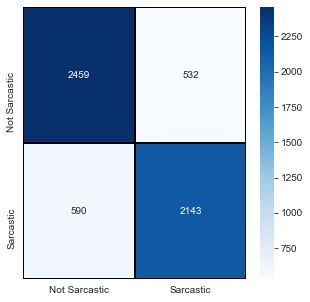

In [81]:
#lets use confusion matrix to check on predictions
conmat=confusion_matrix(y_test,predict)
conmat = pd.DataFrame(conmat , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (5,5))
sns.heatmap(conmat,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic']);

In [82]:
#check classification report
print('accuracy %s' % accuracy_score(predict, y_test))
print(classification_report(y_test, predict,target_names=['sarcasm','non-sarcasm']))

accuracy 0.8039832285115304
              precision    recall  f1-score   support

     sarcasm       0.81      0.82      0.81      2991
 non-sarcasm       0.80      0.78      0.79      2733

    accuracy                           0.80      5724
   macro avg       0.80      0.80      0.80      5724
weighted avg       0.80      0.80      0.80      5724



In [83]:
# get index of values of getting headline  
r=y_test.index

In [84]:
# Create a funcation to check test data is sarcastic or non-sarcastic
def sarcasm(a,b):
    for i,j in zip(a,b):
        print("Input Sentence:- "+df.headline[j]+"\n")
        result = i
        if (result[0]==1):
            pos=1
        else:
            pos=0
        sentiment_dict = {0:'No Sarcasm',1:'Sarcasm'}
        print("Output:- "+sentiment_dict[pos] +"\n" )
    return      

In [85]:
# check first 10 headline of test data  
sarcasm(predict[:10],r[:10]) 

Input Sentence:- frantic lastsecond study finds oldfashioned donut better bavarian cream

Output:- Sarcasm

Input Sentence:- 3 unlikely artists im obsessing year

Output:- No Sarcasm

Input Sentence:- madcap romp escalates zany hijinks

Output:- No Sarcasm

Input Sentence:- 7 stages potty training

Output:- No Sarcasm

Input Sentence:- hubris rewarded

Output:- Sarcasm

Input Sentence:- gop prays ossoff lossoff

Output:- No Sarcasm

Input Sentence:- dad hands phone mom immediately wished happy fathers day

Output:- Sarcasm

Input Sentence:- danielle laportes white hot truth soothes selfhelp fatigue

Output:- No Sarcasm

Input Sentence:- nikki lost 89 pounds mom will tell scheduling time exercise hard

Output:- Sarcasm

Input Sentence:- redbox debuts new touchscreen back kiosk pornographic features

Output:- Sarcasm



## Thank you for review                                                                            
                                                                         submitted by: Arun Kumar
                                                                         arunk.recs.cse@gmail.com